In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
df = pd.read_csv('../input/ICEAirKYKM20191016.csv', header=1)

In [49]:
df.columns

Index(['Date', 'Flight count', 'Flight number', 'Tail number', 'Operator',
       'Owner', 'Previous Airport', 'Next Airport',
       'From NWDC - Boarded Plane', 'From Plane - Boarded Bus to NWDC',
       'From NWDC - Boarded Plane.1', 'From Plane - Boarded Bus to NWDC.1',
       '# Buses', 'Observations', 'Link'],
      dtype='object')

In [50]:
df = df.drop(['From NWDC - Boarded Plane.1', 'From Plane - Boarded Bus to NWDC.1'], axis=1)

In [51]:
df = df.rename({'From NWDC - Boarded Plane': 'Pickups', 'From Plane - Boarded Bus to NWDC': 'Dropoffs'}, axis=1)

In [52]:
df = df.drop(range(34, len(df)))

In [53]:
df['Date'] = pd.to_datetime(df['Date'])

In [54]:
df.set_index('Date', inplace=True)

In [55]:
df.loc[:,['Pickups', 'Dropoffs']] = df[['Pickups', 'Dropoffs']].replace('-', np.nan)

In [56]:
df.loc[:,['Pickups', 'Dropoffs']] = df.loc[:,['Pickups', 'Dropoffs']].astype(float)

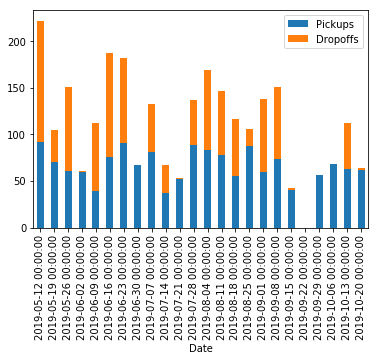

In [62]:
df.resample('W')[['Pickups', 'Dropoffs']].sum().plot(kind='bar', stacked=True);

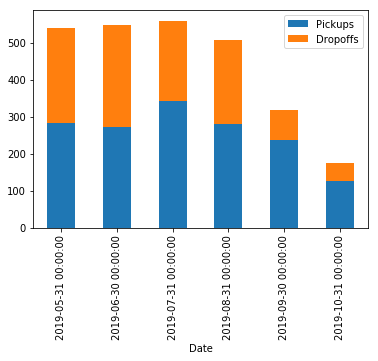

In [61]:
df.resample('M')[['Pickups', 'Dropoffs']].sum().plot(kind='bar', stacked=True);